## Capstone project 3 
### Automated Customer Complaint Classification
### Data wrangling

In [136]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# from sklearn.metrics import plot_roc_curve
# from pprint import pprint

In [6]:
import warnings
warnings.filterwarnings('ignore', category=SyntaxWarning)

In [24]:
# Opening Saved file 
df_clean = pd.read_parquet('df_final.parquet')


In [25]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

In [28]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

In [29]:
dtm

<21072x7247 sparse matrix of type '<class 'numpy.float64'>'
	with 636326 stored elements in Compressed Sparse Row format>

In [31]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5
#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [32]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

7247

In [33]:
H = nmf_model.components_       # Topic-term matrix
H.shape

(5, 7247)

In [34]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,money,fund,chase,deposit,branch,day,number,transaction,customer,transfer,claim,business
Topic 2,credit,card,report,inquiry,chase,account,score,company,information,debt,limit,application,letter,balance,reporting
Topic 3,payment,balance,month,fee,statement,time,auto,date,pay,credit,chase,account,mortgage,car,error
Topic 4,charge,card,chase,dispute,transaction,fee,merchant,fraud,claim,purchase,service,time,refund,statement,company
Topic 5,loan,mortgage,home,modification,chase,property,letter,rate,document,time,bank,house,foreclosure,sale,information


**Observation**
Looking at the topics above, for each topic, we can give a label based on their products/services:

- Topic 1 = Bank account services
- Topic 2 = Credit card / Prepaid card
- Topic 3 = Others
- Topic 4 = Theft/Dispute reporting
- Topic 5 = Mortgages/loans

In [37]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)

In [88]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis=1)

In [98]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(3)
df_clean_5.sort_values('Topic')

,complaint_what_happened,Complaint_clean,Topic
1,good morning my name is and i appreciate it ...,morning name stop bank cardmember service ask ...,0
14,my grand son give me check for deposit it int...,son deposit chase account fund bank account pa...,0
17,with out notice jp morgan chase restricted my ...,jp chase account debit card tuesday thursday b...,0
2,i upgraded my card in was told by the agent...,card agent upgrade date agent information orde...,1
10,chase card was reported on fraudulent applica...,card application identity consent service cred...,1
11,on trying to book a ticket i came across ...,try book ticket offer ticket card information ...,1
20,during the summer months i experience a declin...,summer month income employment month payment e...,2
58,i made a purchase of i made payments of an...,purchase payment payment date statement statem...,2
82,i recently called to ask chase bank why they r...,bank credit bureau payment info bill balance b...,2
21,on made a to an online retailer using chase...,online retailer use pay chase website website ...,3


In [99]:
#Create the dictionary of Topic names and Topics
Topic_names = { 0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Others",
               3:"Theft/Dispute reporting", 4:"Mortgages/loans" }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [100]:
df_clean.head()

,complaint_what_happened,Complaint_clean,Topic
1,good morning my name is and i appreciate it ...,morning name stop bank cardmember service ask ...,Bank account services
2,i upgraded my card in was told by the agent...,card agent upgrade date agent information orde...,Credit card / Prepaid card
10,chase card was reported on fraudulent applica...,card application identity consent service cred...,Credit card / Prepaid card
11,on trying to book a ticket i came across ...,try book ticket offer ticket card information ...,Credit card / Prepaid card
14,my grand son give me check for deposit it int...,son deposit chase account fund bank account pa...,Bank account services


In [103]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaint_what_happened', 'Topic']]


In [112]:
#Write your code to get the Vector count
vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['complaint_what_happened'])

# Save word vector
pickle.dump(vect.vocabulary_, open("count_vector.pk1", "wb"))

In [113]:
#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

# Save tfidf
pickle.dump(tfidf_transformer, open('tfidf.pk1', "wb"))

In [168]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

In [169]:
lr = LogisticRegression(random_state=42, solver='liblinear')
lr.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [170]:
# Getting the score of the base model
lr.score(X_test, y_test)

0.9191343963553531

In [122]:
logreg_grid = {"C": [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                "solver": ["liblinear"]}

In [123]:
# Setup grid hyperparameter search for LogisticRegression
logreg_hpt = GridSearchCV(LogisticRegression(random_state=42),
                                param_grid=logreg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
logreg_hpt.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [125]:
# Check best parameters
logreg_hpt.best_params_

{'C': 3, 'solver': 'liblinear'}

In [126]:
# Evaluating the tuned model
logreg_hpt.score(X_test, y_test)

0.9225512528473804

In [128]:
# Save Logistic Regression Model
pickle.dump(logreg_hpt, open("logreg_model.pk1", "wb"))

In [129]:
# Load pickled model
logreg_model = pickle.load(open("logreg_model.pk1", "rb"))

In [130]:
# Make predictions on test data
y_pred = logreg_model.predict(X_test)

In [131]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1238   19   14    5   29]
 [  16 1183    7    5   49]
 [  21   24  839    9   14]
 [  10   19   18  499   22]
 [  68   40   15    4 1101]]


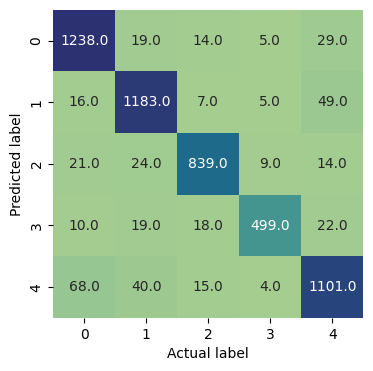

In [133]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="crest", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [134]:
Topicnames_target = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]

In [135]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.92      0.95      0.93      1305
Credit card / Prepaid card       0.92      0.94      0.93      1260
                    Others       0.94      0.93      0.93       907
   Theft/Dispute reporting       0.96      0.88      0.92       568
           Mortgages/loans       0.91      0.90      0.90      1228

                  accuracy                           0.92      5268
                 macro avg       0.93      0.92      0.92      5268
              weighted avg       0.92      0.92      0.92      5268



In [171]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [172]:
# Getting the score of the base model
dt.score(X_test, y_test)

0.7780941533788914

In [173]:
dt_grid = {"max_depth": [3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [175]:
# Setup grid hyperparameter search for DecisionTreeClassifier
dt_hpt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                                param_grid=dt_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
dt_hpt.fit(X_train, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


In [176]:
# Check best parameters
dt_hpt.best_params_

{'max_depth': 10, 'min_samples_leaf': 11, 'min_samples_split': 2}

In [177]:
# Save DecisionTreeClassifier Model
pickle.dump(dt_hpt, open("dt_model.pk1", "wb"))

In [178]:
# Load pickled model
dt_model = pickle.load(open("dt_model.pk1", "rb"))

In [179]:
# Make predictions on test data
y_pred = dt_model.predict(X_test)

In [180]:
print(confusion_matrix(y_test, y_pred))

[[1024   67   21   16  177]
 [  31 1010   20   16  183]
 [  36   27  642   37  165]
 [  45   49   22  423   29]
 [ 145  112   15   23  933]]


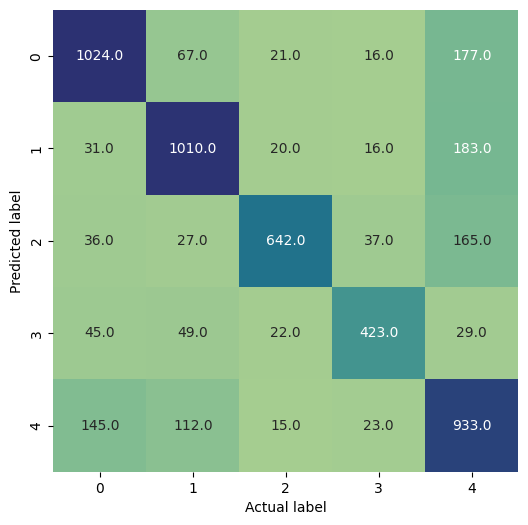

In [181]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="crest", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [182]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.80      0.78      0.79      1305
Credit card / Prepaid card       0.80      0.80      0.80      1260
                    Others       0.89      0.71      0.79       907
   Theft/Dispute reporting       0.82      0.74      0.78       568
           Mortgages/loans       0.63      0.76      0.69      1228

                  accuracy                           0.77      5268
                 macro avg       0.79      0.76      0.77      5268
              weighted avg       0.78      0.77      0.77      5268



In [183]:
# Importing Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier
# Importing Train, Test Split
from sklearn.model_selection import train_test_split

In [184]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

In [185]:
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [186]:
# Getting the score of the base model
rf.score(X_test, y_test)

0.8202353834472286

In [187]:
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [188]:
# Setup random hyperparameter search for Random Forest
rf_hpt = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
rf_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\pmani\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
# Check best parameters
rf_hpt.best_params_

{'n_estimators': 860,
 'min_samples_split': 12,
 'min_samples_leaf': 1,
 'max_depth': 10}

In [ ]:
# Evaluating the tuned model
rf_hpt.score(X_test, y_test)

0.7355732725892179

In [ ]:
rf_grid = {"n_estimators": [200, 260, 300],
           "max_depth": [7, 10, 15],
           "min_samples_split": [10, 12, 14],
           "min_samples_leaf": [6, 8, 10]}

In [ ]:
# Setup grid hyperparameter search for Random Forest
rf_hpt = GridSearchCV(RandomForestClassifier(random_state=42),
                                param_grid=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
rf_hpt.fit(X_train, y_train);

In [ ]:
# Check best parameters
rf_hpt.best_params_

{'n_estimators': 860,
 'min_samples_split': 12,
 'min_samples_leaf': 1,
 'max_depth': 10}

In [ ]:
# Evaluating the tuned model
rf_hpt.score(X_test, y_test)

0.7355732725892179

In [ ]:
# Save Random Forest Model
pickle.dump(rf_hpt, open("rf_model.pk1", "wb"))

In [ ]:
# Load pickled model
rf_model = pickle.load(open("rf_model.pk1", "rb"))

In [ ]:
# Make predictions on test data
y_pred = rf_model.predict(X_test)

In [ ]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1187   81    4    0   33]
 [  71 1066    3    0  120]
 [  80  128  677    0   22]
 [ 155  202   92    4  114]
 [ 160  124    4    0  941]]


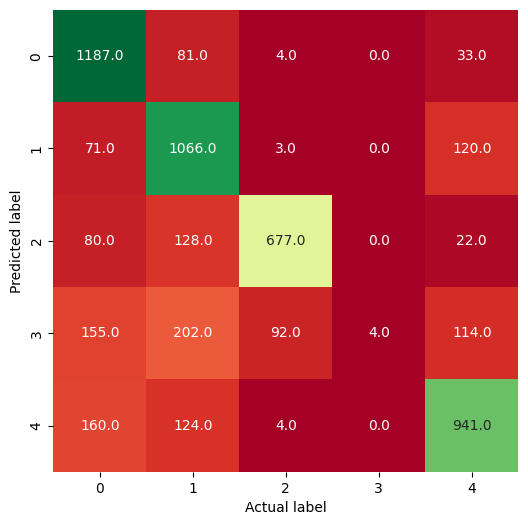

In [ ]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="crest", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [ ]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.72      0.91      0.80      1305
Credit card / Prepaid card       0.67      0.85      0.75      1260
                    Others       0.87      0.75      0.80       907
   Theft/Dispute reporting       1.00      0.01      0.01       567
           Mortgages/loans       0.77      0.77      0.77      1229

                  accuracy                           0.74      5268
                 macro avg       0.80      0.65      0.63      5268
              weighted avg       0.77      0.74      0.70      5268

